In [2]:
import re
import pandas as pd
import pyttsx3
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier, _tree
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
import csv
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

training = pd.read_csv('Data/Training.csv')
testing = pd.read_csv('Data/Testing.csv')
cols = training.columns
cols = cols[:-1]
x = training[cols]
y = training['prognosis']
y1 = y

reduced_data = training.groupby(training['prognosis']).max()

# mapping strings to numbers
le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
testx = testing[cols]
testy = testing['prognosis']
testy = le.transform(testy)

clf1 = DecisionTreeClassifier()
clf = clf1.fit(x_train, y_train)
scores = cross_val_score(clf, x_test, y_test, cv=3)
print(scores.mean())

model = SVC()
model.fit(x_train, y_train)
print("for svm: ")
y_pred = model.predict(x_test)
print(model.score(x_test, y_test))

importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
features = cols

def readn(nstr):
    engine = pyttsx3.init()
    engine.setProperty('voice', "english+f5")
    engine.setProperty('rate', 130)
    engine.say(nstr)
    engine.runAndWait()
    engine.stop()

def speak_and_print(nstr):
    print(nstr)
    readn(nstr)

severityDictionary = dict()
description_list = dict()
precautionDictionary = dict()

symptoms_dict = {}

for index, symptom in enumerate(x):
    symptoms_dict[symptom] = index

def calc_condition(exp, days):
    sum = 0
    for item in exp:
        sum += severityDictionary[item]
    if (sum * days) / (len(exp) + 1) > 13:
        speak_and_print("You should take the consultation from a doctor.")
    else:
        speak_and_print("It might not be that bad, but you should take precautions.")
        print("It might not be that bad, but you should take precautions.")

def getDescription():
    global description_list
    with open('MasterData/symptom_Description.csv') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            _description = {row[0]: row[1]}
            description_list.update(_description)

def getSeverityDict():
    global severityDictionary
    with open('MasterData/symptom_severity.csv') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        try:
            for row in csv_reader:
                _diction = {row[0]: int(row[1])}
                severityDictionary.update(_diction)
        except:
            pass

def getprecautionDict():
    global precautionDictionary
    with open('MasterData/symptom_precaution.csv') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            _prec = {row[0]: [row[1], row[2], row[3], row[4]]}
            precautionDictionary.update(_prec)

def getInfo():
    speak_and_print("-----------------------------------HealthCare ChatBot-----------------------------------")
    speak_and_print("Welcome to the HealthCare ChatBot.")
    speak_and_print("May I know your name?")
    name = input("")
    speak_and_print(f"Hello, {name}!")

def check_pattern(dis_list, inp):
    pred_list = []
    inp = inp.replace(' ', '_')
    patt = f"{inp}"
    regexp = re.compile(patt)
    pred_list = [item for item in dis_list if regexp.search(item)]
    if len(pred_list) > 0:
        return 1, pred_list
    else:
        return 0, []

def sec_predict(symptoms_exp):
    df = pd.read_csv('Data/Training.csv')
    X = df.iloc[:, :-1]
    y = df['prognosis']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)
    rf_clf = DecisionTreeClassifier()
    rf_clf.fit(X_train, y_train)

    symptoms_dict = {symptom: index for index, symptom in enumerate(X)}
    input_vector = np.zeros(len(symptoms_dict))
    for item in symptoms_exp:
        input_vector[[symptoms_dict[item]]] = 1

    return rf_clf.predict([input_vector])

def print_disease(node):
    node = node[0]
    val = node.nonzero()
    disease = le.inverse_transform(val[0])
    return list(map(lambda x: x.strip(), list(disease)))

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    chk_dis = ",".join(feature_names).split(",")
    symptoms_present = []

    while True:
        speak_and_print("Enter the symptom you are experiencing:")
        disease_input = input("")
        conf, cnf_dis = check_pattern(chk_dis, disease_input)
        if conf == 1:
            speak_and_print("Searches related to input:")
            for num, it in enumerate(cnf_dis):
                speak_and_print(f"{num}) {it}")
            if num != 0:
                speak_and_print(f"Select the one you meant (0 - {num}):")
                conf_inp = int(input(""))
            else:
                conf_inp = 0

            disease_input = cnf_dis[conf_inp]
            break
        else:
            speak_and_print("Enter a valid symptom.")

    while True:
        try:
            num_days = int(input("Okay. For how many days have you been experiencing this?: "))
            break
        except:
            speak_and_print("Enter a valid input.")

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]

            if name == disease_input:
                val = 1
            else:
                val = 0
            if val <= threshold:
                recurse(tree_.children_left[node], depth + 1)
            else:
                symptoms_present.append(name)
                recurse(tree_.children_right[node], depth + 1)
        else:
            present_disease = print_disease(tree_.value[node])
            red_cols = reduced_data.columns
            symptoms_given = red_cols[reduced_data.loc[present_disease].values[0].nonzero()]
            speak_and_print("Are you experiencing any:")
            symptoms_exp = []
            for syms in list(symptoms_given):
                inp = ""
                speak_and_print(f"{syms}? (yes/no):")
                while True:
                    inp = input("").lower()
                    if inp == "yes" or inp == "no":
                        break
                    else:
                        speak_and_print("Please provide a proper answer (yes/no):")
                if inp == "yes":
                    symptoms_exp.append(syms)

            second_prediction = sec_predict(symptoms_exp)
            calc_condition(symptoms_exp, num_days)
            if present_disease[0] == second_prediction[0]:
                speak_and_print(f"You may have {present_disease[0]}.")
                speak_and_print(description_list.get(present_disease[0], ""))
            else:
                speak_and_print(f"You may have {present_disease[0]} or {second_prediction[0]}.")
                speak_and_print(description_list.get(present_disease[0], ""))
                speak_and_print(description_list.get(second_prediction[0], ""))

            precution_list = precautionDictionary.get(present_disease[0], [])
            speak_and_print("Take the following measures:")
            for i, j in enumerate(precution_list, start=1):
                speak_and_print(f"{i}) {j}")

    recurse(0, 1)

getSeverityDict()
getDescription()
getprecautionDict()
getInfo()
tree_to_code(clf, cols)
speak_and_print("----------------------------------------------------------------------------------------")


0.9778336323104452
for svm: 
1.0
-----------------------------------HealthCare ChatBot-----------------------------------
Welcome to the HealthCare ChatBot.
May I know your name?
a
Hello, a!
Enter the symptom you are experiencing:
back pain
Searches related to input:
0) back_pain
Okay. For how many days have you been experiencing this?: 3
Are you experiencing any:
back_pain? (yes/no):
yes
weakness_in_limbs? (yes/no):
no
neck_pain? (yes/no):
no
dizziness? (yes/no):
yes
loss_of_balance? (yes/no):
no


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


It might not be that bad, but you should take precautions.
It might not be that bad, but you should take precautions.
You may have Cervical spondylosis or Dengue.
Cervical spondylosis is a general term for age-related wear and tear affecting the spinal disks in your neck. As the disks dehydrate and shrink, signs of osteoarthritis develop, including bony projections along the edges of bones (bone spurs).
an acute infectious disease caused by a flavivirus (species Dengue virus of the genus Flavivirus), transmitted by aedes mosquitoes, and characterized by headache, severe joint pain, and a rash. â€” called also breakbone fever, dengue fever.
Take the following measures:
1) use heating pad or cold pack
2) exercise
3) take otc pain reliver
4) consult doctor
----------------------------------------------------------------------------------------


In [2]:
# import matplotlib.pyplot as plt

In [3]:
model = SVC()
model.fit(x_train, y_train)
print("for svm: ")
y_pred = model.predict(x_test)
#print(model.score(x_test, y_test))

for svm: 


In [6]:
clf1 = DecisionTreeClassifier()
clf1.fit(x_train, y_train)
y_pred = clf1.predict(x_test)
print(accuracy_score(y_test, y_pred))

1.0


In [5]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,y_pred))

1.0


In [7]:
from sklearn.metrics import confusion_matrix

In [20]:
import seaborn as sns

In [13]:
print(confusion_matrix(y_test,y_pred))

[[37  0  0 ...  0  0  0]
 [ 0 42  0 ...  0  0  0]
 [ 0  0 42 ...  0  0  0]
 ...
 [ 0  0  0 ... 41  0  0]
 [ 0  0  0 ...  0 40  0]
 [ 0  0  0 ...  0  0 44]]


In [26]:
z = pd.DataFrame(y)

In [30]:
df = pd.concat([x,z],axis=1)

<Axes: >

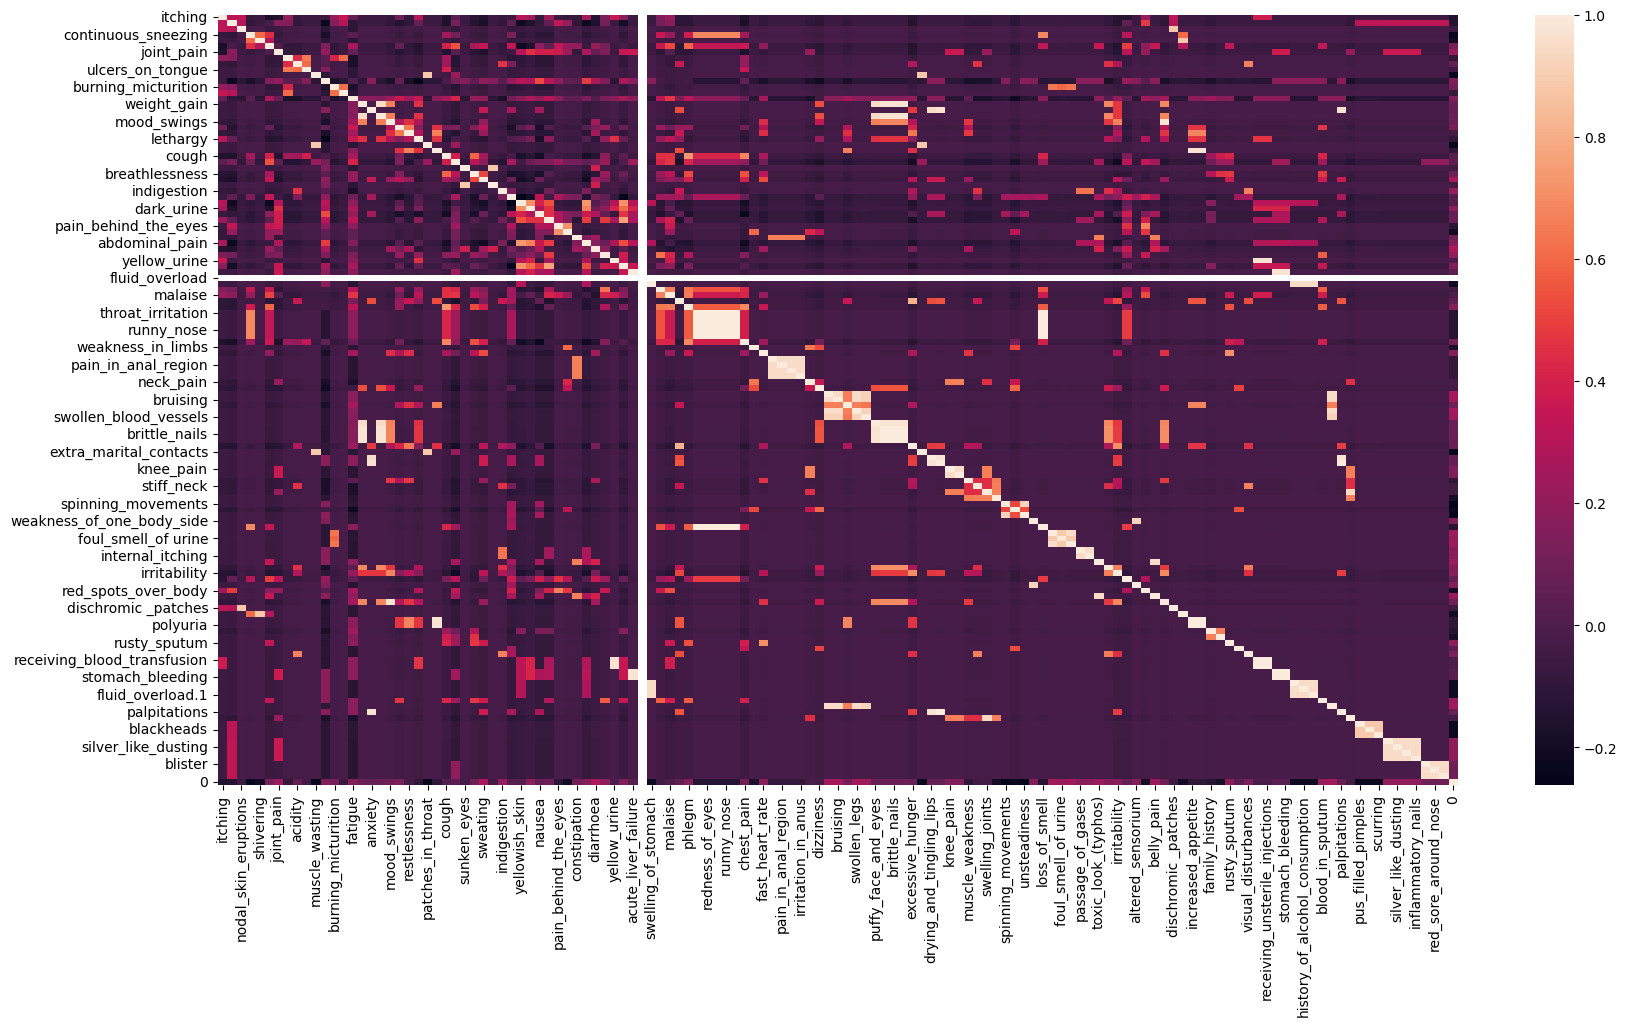

In [34]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr())

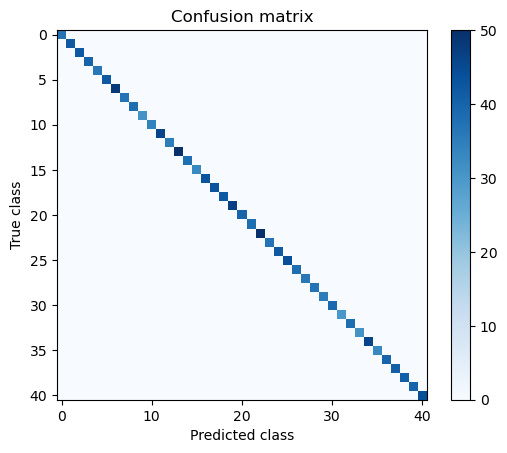

In [11]:
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.title('Confusion matrix')
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.show()